<a href="https://colab.research.google.com/github/flybiubiu/cs231n/blob/master/LSTM_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/Halfish/cs231n.git
!ls -al
%cd cs231n/assignment3
!pip install imageio
%cd cs231n/datasets/
!/content/cs231n/assignment3/cs231n/datasets/get_coco_captioning.sh
!/content/cs231n/assignment3/cs231n/datasets/get_tiny_imagenet_a.sh
!/content/cs231n/assignment3/cs231n/datasets/get_pretrained_model.sh
%cd '/content/cs231n/assignment3'

fatal: destination path 'cs231n' already exists and is not an empty directory.
total 7376
drwxr-xr-x 3 root root    4096 Jan 10 06:50 .
drwxr-xr-x 6 root root    4096 Jan 10 06:50 ..
-rwxr-xr-x 1 root root     193 Jan 10 06:50 collectSubmission.sh
drwxr-xr-x 4 root root    4096 Jan 10 06:50 cs231n
-rwxr-xr-x 1 root root     412 Jan 10 06:50 frameworkpython
-rw-r--r-- 1 root root      19 Jan 10 06:50 .gitignore
-rw-r--r-- 1 root root 1061596 Jan 10 06:50 ImageGeneration.ipynb
-rw-r--r-- 1 root root  875597 Jan 10 06:50 ImageGradients.ipynb
-rw-r--r-- 1 root root   21355 Jan 10 06:50 kitten.jpg
-rw-r--r-- 1 root root 1570559 Jan 10 06:50 LSTM_Captioning.ipynb
-rw-r--r-- 1 root root     801 Jan 10 06:50 requirements.txt
-rw-r--r-- 1 root root 3827488 Jan 10 06:50 RNN_Captioning.ipynb
-rw-r--r-- 1 root root  148465 Jan 10 06:50 sky.jpg
-rwxr-xr-x 1 root root     113 Jan 10 06:50 start_ipython_osx.sh
[Errno 2] No such file or directory: 'cs231n/assignment3'
/content/cs231n/assignment3
/cont

In [3]:
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
def rel_error(x, y):
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [11]:
data = load_coco_data(pca_features=True)
for k, v in data.iteritems():
  if type(v) == np.ndarray:
    print k, type(v), v.shape, v.dtype
  else:
    print k, type(v), len(v)

idx_to_word <type 'list'> 1004
train_captions <type 'numpy.ndarray'> (400135, 17) int32
val_captions <type 'numpy.ndarray'> (195954, 17) int32
train_image_idxs <type 'numpy.ndarray'> (400135,) int32
val_features <type 'numpy.ndarray'> (40504, 512) float32
val_image_idxs <type 'numpy.ndarray'> (195954,) int32
train_features <type 'numpy.ndarray'> (82783, 512) float32
train_urls <type 'numpy.ndarray'> (82783,) |S63
val_urls <type 'numpy.ndarray'> (40504,) |S63
word_to_idx <type 'dict'> 1004


In [16]:
N, D, H = 3, 4, 5
x = np.linspace(-0.4, 1.2, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.3, 0.7, num=N*H).reshape(N, H)
prev_c = np.linspace(-0.4, 0.9, num=N*H).reshape(N, H)
Wx = np.linspace(-2.1, 1.3, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.7, 2.2, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.3, 0.7, num=4*H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

expected_next_h = np.asarray([
    [ 0.24635157,  0.28610883,  0.32240467,  0.35525807,  0.38474904],
    [ 0.49223563,  0.55611431,  0.61507696,  0.66844003,  0.7159181 ],
    [ 0.56735664,  0.66310127,  0.74419266,  0.80889665,  0.858299  ]])
expected_next_c = np.asarray([
    [ 0.32986176,  0.39145139,  0.451556,    0.51014116,  0.56717407],
    [ 0.66382255,  0.76674007,  0.87195994,  0.97902709,  1.08751345],
    [ 0.74192008,  0.90592151,  1.07717006,  1.25120233,  1.42395676]])

print 'next_h error: ', rel_error(expected_next_h, next_h)
print 'next_c error: ', rel_error(expected_next_c, next_c)

next_h error:  5.7054131967097955e-09
next_c error:  5.8143123088804145e-09


In [17]:
x = np.random.randn(N, D)
prev_h = np.random.randn(N, H)
prev_c = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

next_h, next_c, cache = lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)

dnext_h = np.random.randn(*next_h.shape)
dnext_c = np.random.randn(*next_c.shape)

fx_h = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fh_h = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fc_h = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWx_h = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fWh_h = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]
fb_h = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[0]

fx_c = lambda x: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fh_c = lambda h: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fc_c = lambda c: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWx_c = lambda Wx: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fWh_c = lambda Wh: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]
fb_c = lambda b: lstm_step_forward(x, prev_h, prev_c, Wx, Wh, b)[1]

num_grad = eval_numerical_gradient_array

dx_num = num_grad(fx_h, x, dnext_h) + num_grad(fx_c, x, dnext_c)
dh_num = num_grad(fh_h, prev_h, dnext_h) + num_grad(fh_c, prev_h, dnext_c)
dc_num = num_grad(fc_h, prev_c, dnext_h) + num_grad(fc_c, prev_c, dnext_c)
dWx_num = num_grad(fWx_h, Wx, dnext_h) + num_grad(fWx_c, Wx, dnext_c)
dWh_num = num_grad(fWh_h, Wh, dnext_h) + num_grad(fWh_c, Wh, dnext_c)
db_num = num_grad(fb_h, b, dnext_h) + num_grad(fb_c, b, dnext_c)

dx, dh, dc, dWx, dWh, db = lstm_step_backward(dnext_h, dnext_c, cache)

print 'dx error: ', rel_error(dx_num, dx)
print 'dh error: ', rel_error(dh_num, dh)
print 'dc error: ', rel_error(dc_num, dc)
print 'dWx error: ', rel_error(dWx_num, dWx)
print 'dWh error: ', rel_error(dWh_num, dWh)
print 'db error: ', rel_error(db_num, db)

dx error:  4.508226629975196e-10
dh error:  3.965838548183545e-10
dc error:  3.439024986109902e-08
dWx error:  6.026312066714484e-09
dWh error:  3.741343610585127e-08
db error:  1.503232930596698e-10


In [18]:
N, D, H, T = 2, 5, 4, 3
x = np.linspace(-0.4, 0.6, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.4, 0.8, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.9, num=4*D*H).reshape(D, 4 * H)
Wh = np.linspace(-0.3, 0.6, num=4*H*H).reshape(H, 4 * H)
b = np.linspace(0.2, 0.7, num=4*H)

h, cache = lstm_forward(x, h0, Wx, Wh, b)

expected_h = np.asarray([
 [[ 0.01764008,  0.01823233,  0.01882671,  0.0194232 ],
  [ 0.11287491,  0.12146228,  0.13018446,  0.13902939],
  [ 0.31358768,  0.33338627,  0.35304453,  0.37250975]],
 [[ 0.45767879,  0.4761092,   0.4936887,   0.51041945],
  [ 0.6704845,   0.69350089,  0.71486014,  0.7346449 ],
  [ 0.81733511,  0.83677871,  0.85403753,  0.86935314]]])

print 'h error: ', rel_error(expected_h, h)

h error:  8.610537452106624e-08


In [19]:
from cs231n.rnn_layers import lstm_forward, lstm_backward

N, D, T, H = 2, 3, 10, 6

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, 4 * H)
Wh = np.random.randn(H, 4 * H)
b = np.random.randn(4 * H)

out, cache = lstm_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = lstm_backward(dout, cache)

fx = lambda x: lstm_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: lstm_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: lstm_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: lstm_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: lstm_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print 'dx error: ', rel_error(dx_num, dx)
print 'dh0 error: ', rel_error(dx_num, dx)
print 'dWx error: ', rel_error(dx_num, dx)
print 'dWh error: ', rel_error(dx_num, dx)
print 'db error: ', rel_error(dx_num, dx)

dx error:  9.093842296513988e-10
dh0 error:  9.093842296513988e-10
dWx error:  9.093842296513988e-10
dWh error:  9.093842296513988e-10
db error:  9.093842296513988e-10


In [20]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='lstm',
          dtype=np.float64)

for k, v in model.params.iteritems():
  model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-0.5, 1.7, num=N*D).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.82445935443

print 'loss: ', loss
print 'expected loss: ', expected_loss
print 'difference: ', abs(loss - expected_loss)

loss:  9.824459354432264
expected loss:  9.82445935443
difference:  2.2648549702353193e-12


(Iteration 1 / 100) loss: 79.057544
(Iteration 11 / 100) loss: 39.527964
(Iteration 21 / 100) loss: 21.556458
(Iteration 31 / 100) loss: 10.824624
(Iteration 41 / 100) loss: 4.848441
(Iteration 51 / 100) loss: 7.021871
(Iteration 61 / 100) loss: 1.063921
(Iteration 71 / 100) loss: 0.392017
(Iteration 81 / 100) loss: 0.197751
(Iteration 91 / 100) loss: 0.144049


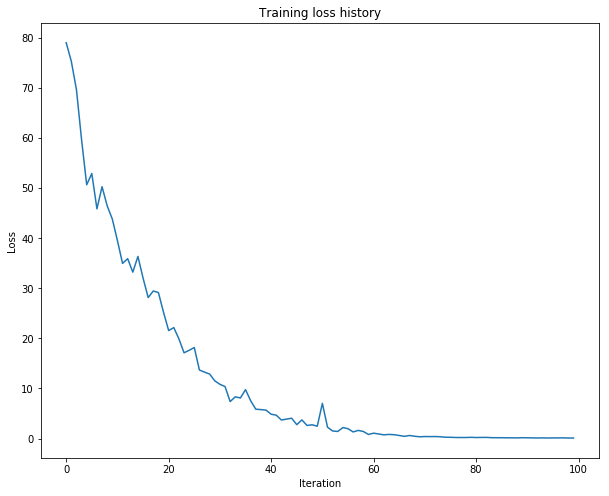

In [21]:
small_data = load_coco_data(max_train=50)

small_lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
          dtype=np.float32,
        )

small_lstm_solver = CaptioningSolver(small_lstm_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.995,
           verbose=True, print_every=10,
         )

small_lstm_solver.train()

# Plot the training losses
plt.plot(small_lstm_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()